In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import matplotlib.pyplot as plt
    import seaborn as sns

    from simgen.project import Project
    import mbuild as mb
    import metamds as mds
    import mdtraj as md
    #from mdtraj.html import TrajectorySliderView
    
%matplotlib inline
!rm -rf simgen_output/ *.top *.gro

In [2]:
github_project_url = 'https://github.com/iModels/demos/demos/ethane_box/binary_lj_sim'

In [3]:
from simgen.mdsblocks.editor import Editor
editor = Editor('<place_your_GitHub_token_here>', github_project_url)
editor.show()

In [4]:
editor.finished

AttributeError: 'Editor' object has no attribute 'finished'

In [5]:
def build_ethane_box(box, n_molecules, **kwargs):
    from mbuild.examples import Ethane
    ethane = Ethane()
    full_box = mb.fill_box(ethane, n_molecules, box)
    full_box.name = '{}_ethanes'.format(n_molecules)
    return full_box

In [6]:
def create_run_script(**parameters):
    project = Project(github_project_url+'/online_project.yaml')

    return project.render_tasks('prg', output_dir='./', inject_dict=parameters)

In [7]:
# Input parameters
parameters = {'n_molecules': 200,
              'box': [3, 3, 3],
              'forcefield': 'OPLS-aa',
              'system_name': 'ethane_box'}

# Build the initial configuration
compound = build_ethane_box(**parameters)
#compound.visualize()

parameters['compound'] = compound

In [8]:
# Initialize a simulation instance with a template and some metadata
sim = mds.Simulation(name='ethane', template=create_run_script, input_dir='static_input_files', output_dir='simgen_output')

# Parameterize our simulation template
task = sim.parametrize(**parameters)

Cloning repo: imodels/demos
git clone https://github.com/imodels/demos.git


In [9]:
# Run
#task.execute(hostname='rahman.vuse.vanderbilt.edu', username='ctk3b')
task.execute()

INFO:ethane_info:Running: /bin/sh ./minimize_energy.sh
DEBUG:ethane_debug:Analysing residue names:
DEBUG:ethane_debug:There are:   200      Other residues
DEBUG:ethane_debug:Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
DEBUG:ethane_debug:Calculating fourier grid dimensions for X Y Z
DEBUG:ethane_debug:Using a fourier grid of 32x32x32, spacing 0.109 0.110 0.109
DEBUG:ethane_debug:This run will generate roughly 0 Mb of data
DEBUG:ethane_debug:                  :-) GROMACS - gmx grompp, VERSION 5.1.1 (-:
DEBUG:ethane_debug:
DEBUG:ethane_debug:                            GROMACS is written by:
DEBUG:ethane_debug:     Emile Apol      Rossen Apostolov  Herman J.C. Berendsen    Par Bjelkmar   
DEBUG:ethane_debug: Aldert van Buuren   Rudi van Drunen     Anton Feenstra   Sebastian Fritsch 
DEBUG:ethane_debug:  Gerrit Groenhof   Christoph Junghans   Anca Hamuraru    Vincent Hindriksen
DEBUG:ethane_debug: Dimitrios Karkoulis    Peter Kasson        Jiri K

('/Users/sallai/PycharmProjects/demos/demos/ethane_box', '/Users/sallai/PycharmProjects/demos/demos/ethane_box/simgen_output/task_0')
/bin/sh ./minimize_energy.sh
/bin/sh ./nvt.sh

INFO:ethane_info:Running: /bin/sh ./nvt.sh
DEBUG:ethane_debug:turning H bonds into constraints...
DEBUG:ethane_debug:Analysing residue names:
DEBUG:ethane_debug:There are:   200      Other residues
DEBUG:ethane_debug:Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
DEBUG:ethane_debug:Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 298.15 K
DEBUG:ethane_debug:Calculated rlist for 1x1 atom pair-list as 1.000 nm, buffer size 0.000 nm
DEBUG:ethane_debug:Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
DEBUG:ethane_debug:Note that mdrun will redetermine rlist based on the actual pair-list setup
DEBUG:ethane_debug:Calculating fourier grid dimensions for X Y Z
DEBUG:ethane_debug:Using a fourier grid of 32x32x32, spacing 0.109 0.110 0.109
DEBUG:ethane_debug:This run will generate roughly 0 Mb of data
DEBUG:ethane_debug:                  :-) GROMACS - gmx grompp, VERSION 5.1.1 (-:
DEBUG:ethane_debug:
DEBUG:ethane_de

In [10]:
#task.sync()

In [11]:
# Analyze
trajectories = task.get_output_files('trajectories')
topologies = task.get_output_files('topologies')

trj_path = os.path.join(task.output_dir, 'nvt.xtc')
top_path = os.path.join(task.output_dir, 'em.gro')
traj = md.load(trj_path, top=top_path)
print(traj)

<mdtraj.Trajectory with 5 frames, 1600 atoms, 200 residues, and unitcells>


In [12]:
#TrajectorySliderView(traj)

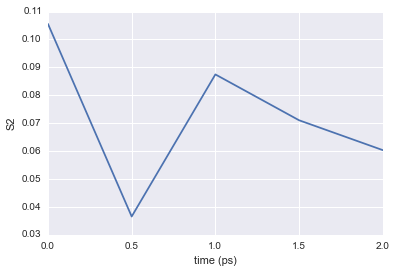

In [13]:
s2 = md.compute_nematic_order(traj, 'residues')
plt.plot(traj.time, s2)
plt.xlabel('time (ps)')
plt.ylabel('S2')

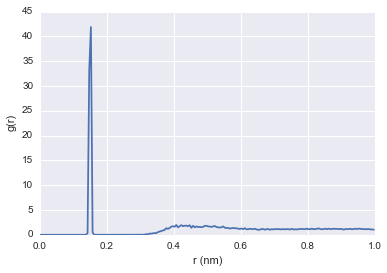

In [14]:
pairs = traj.top.select_pairs('name C', 'name C')
r, g_r = md.compute_rdf(traj, pairs)
plt.plot(r, g_r)
plt.xlabel('r (nm)')
plt.ylabel('g(r)')